In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.ndimage import gaussian_filter
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
data = pd.read_csv('/content/heart.csv')

In [ ]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
data.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


## Preprocessing##

In [ ]:
# Encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [ ]:
# Normalize numerical columns
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

In [ ]:
# Handle class imbalance with SMOTE
X = data_encoded.drop(columns=['HeartDisease'])
y = data_encoded['HeartDisease']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

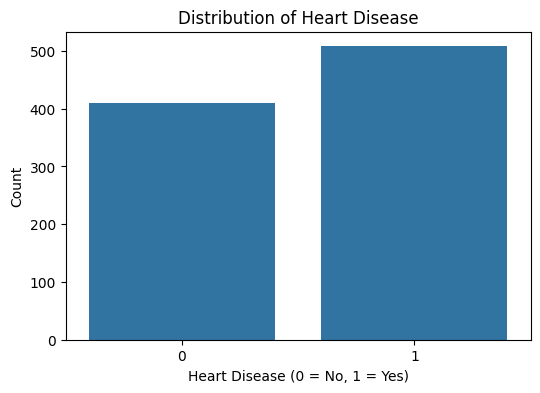

In [ ]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=data)
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

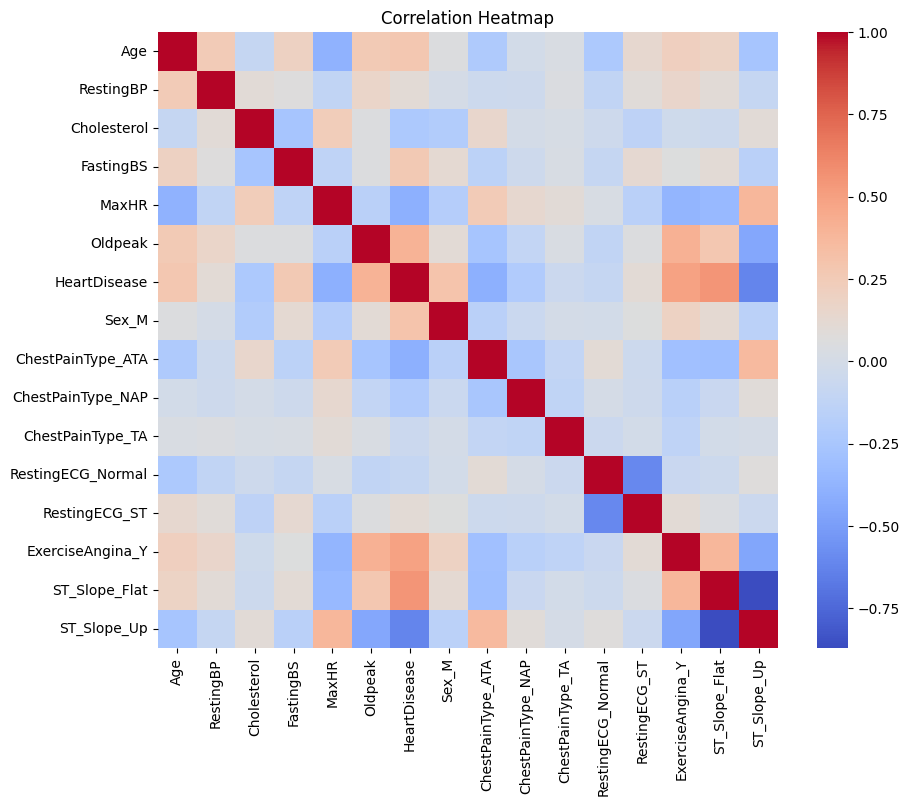

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_encoded.corr(), annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

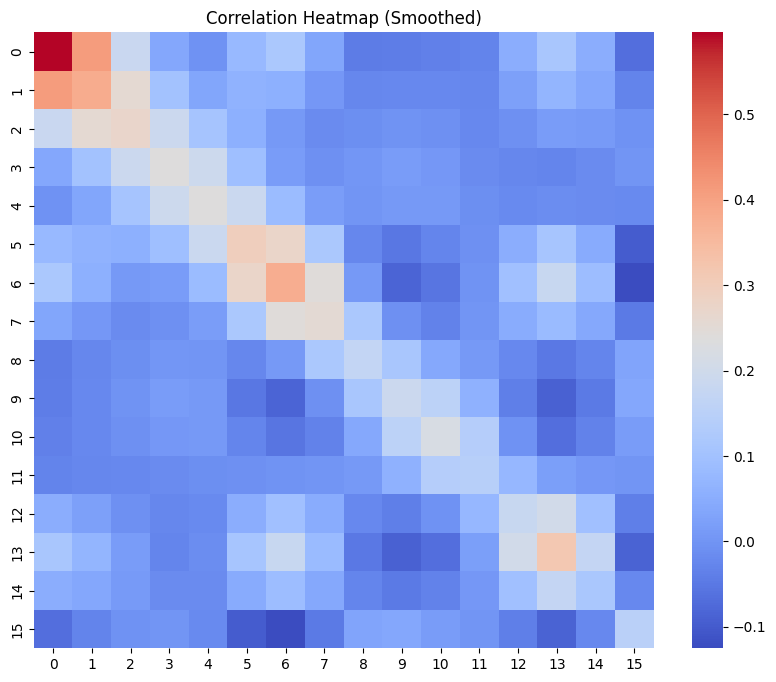

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(gaussian_filter(data_encoded.corr(), sigma=1), annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap (Smoothed)')
plt.show()

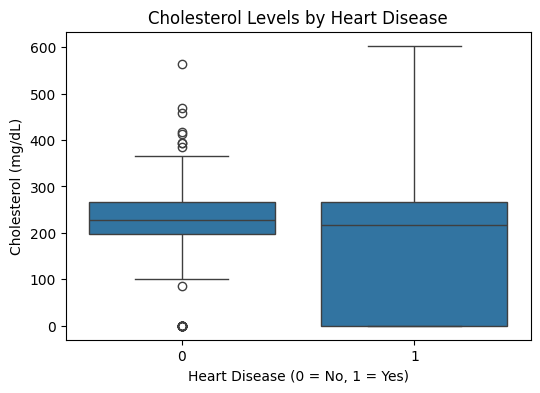

In [ ]:
# Boxplot of cholesterol vs heart disease
plt.figure(figsize=(6, 4))
sns.boxplot(x='HeartDisease', y='Cholesterol', data=data)
plt.title('Cholesterol Levels by Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Cholesterol (mg/dL)')
plt.show()

In [ ]:
# Feature Selection
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_resampled, y_resampled)
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
scores = scores.sort_values(by='Score', ascending=False)

In [ ]:
# Display selected features
print("Top Features:")
print(scores.head(10))


Top Features:
              Feature       Score
14        ST_Slope_Up  705.976864
13      ST_Slope_Flat  483.463337
12   ExerciseAngina_Y  335.934963
5             Oldpeak  220.306618
7   ChestPainType_ATA  197.952191
4               MaxHR  191.549316
0                 Age   92.946334
3           FastingBS   92.844205
6               Sex_M   83.072419
2         Cholesterol   57.586453


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Model training
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Evaluation
predictions = model.predict(X_test)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Confusion Matrix:
[[ 73  15]
 [ 11 105]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        88
           1       0.88      0.91      0.89       116

    accuracy                           0.87       204
   macro avg       0.87      0.87      0.87       204
weighted avg       0.87      0.87      0.87       204



In [ ]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87


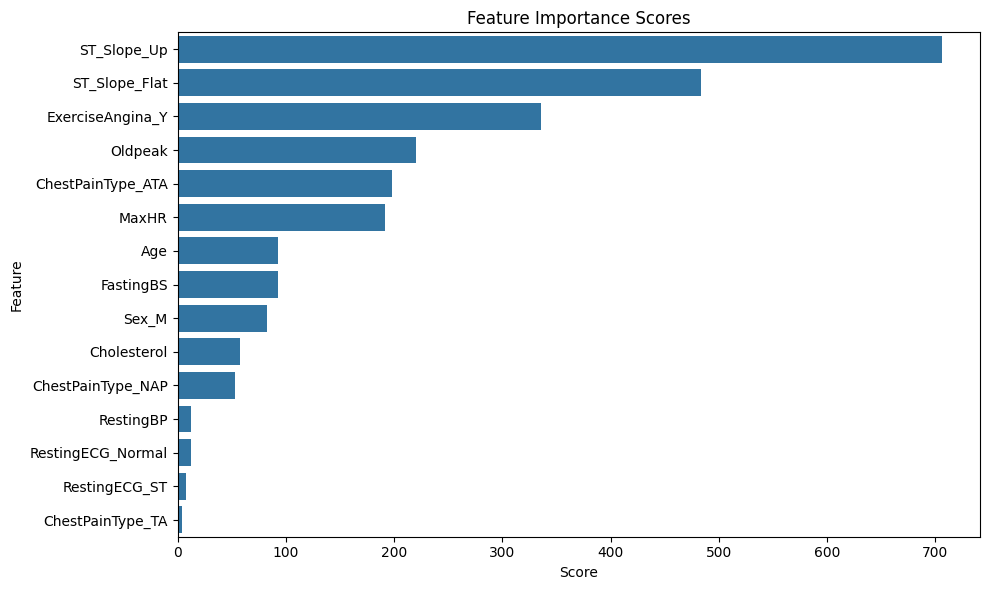

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=scores['Score'], y=scores['Feature'])
plt.title('Feature Importance Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Save the model
import joblib
joblib.dump(model, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']